In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy
import pandas
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
import xgboost as xgb

C:\Users\igosh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\igosh\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def train_test_split_group(group_column, *arrays, **kw_args):
   
    from sklearn import cross_validation
    allow_none = kw_args.pop('allow_none', None)

    assert len(arrays) > 0, "at least one array should be passed"
    length = len(arrays[0])
    for array in arrays:
        assert len(array) == length, "different size"

    initial_data = numpy.array(group_column)
    assert len(initial_data) == length, "group column must have the same length"
    group_ids = numpy.unique(initial_data)

    train_indices, test_indices = cross_validation.train_test_split(group_ids, **kw_args)
    train_indices = numpy.in1d(initial_data, train_indices)
    test_indices = numpy.in1d(initial_data, test_indices)

    result = []
    for array in arrays:
        if isinstance(array, pandas.DataFrame):
            result.append(array.iloc[train_indices, :])
            result.append(array.iloc[test_indices, :])
        elif (array is None) and allow_none:
            # specially for checking weights
            result.append(None)
            result.append(None)
        else:
            result.append(numpy.array(array)[train_indices])
            result.append(numpy.array(array)[test_indices])
    return result

In [274]:
def compute_mean(event_ids, values):
    number_of_sv_in_event = np.bincount(event_ids)
    return np.bincount(event_ids, weights=values) / number_of_sv_in_event

In [88]:
def compute_max(event_ids, values):
    max_values = numpy.zeros(numpy.amax(event_ids) + 1)
    for i in range(len(event_ids)):
        if values[i] > max_values[event_ids[i]]:
            max_values[event_ids[i]] = values[i]
    max_values[max_values == 0] = numpy.nan
    return max_values

In [3]:
data = pd.read_csv("training.csv", sep=",")

In [12]:
features = list(set(data.columns) - {'EventID', 'Label', 'Weight'})
features

['Pt_min',
 'Pt',
 'IP_chi2_sum',
 'Corrected_mass',
 'Pt_sum',
 'Pseudorapidity',
 'Vertex_chi2',
 'Track_number_PV',
 'Flight_distance',
 'IP_chi2',
 'Tracks_number_passed',
 'Mass',
 'Tracks_number']

In [276]:
data.head()

,EventID,Label,Mass,Corrected_mass,Pt,Pt_sum,Pt_min,IP_chi2,IP_chi2_sum,Flight_distance,Pseudorapidity,Track_number_PV,Tracks_number,Tracks_number_passed,Vertex_chi2,Weight
0,0,1,3440.680014,5202.580014,15583.900014,15793.800014,6499.170014,23.863914,281.409014,727.555014,2.581344,0,2,2,1.119164,2.834853
1,0,1,1319.829991,2465.479991,3477.259991,3593.409991,404.050991,34.731791,135.844991,165.981991,2.581401,0,2,1,0.004716,2.834853
2,0,1,2732.810016,5804.080016,9356.570016,9562.870016,406.027016,150.119016,348.274016,414.395016,2.579956,0,2,1,0.016452,2.834853
3,0,1,1674.579998,4423.859998,6889.459998,6981.049998,404.992998,84.545298,167.266998,167.871998,2.585178,0,2,1,0.085944,2.834853
4,0,1,1844.839993,5744.339993,12385.899993,12299.399993,3167.219993,110.864993,251.260993,350.210993,2.590683,0,2,2,1.167173,2.834853


In [13]:
data1 = data[data["Label"] == 1]

In [277]:
data1.head()

,EventID,Label,Mass,Corrected_mass,Pt,Pt_sum,Pt_min,IP_chi2,IP_chi2_sum,Flight_distance,Pseudorapidity,Track_number_PV,Tracks_number,Tracks_number_passed,Vertex_chi2,Weight
0,0,1,3440.680014,5202.580014,15583.900014,15793.800014,6499.170014,23.863914,281.409014,727.555014,2.581344,0,2,2,1.119164,2.834853
1,0,1,1319.829991,2465.479991,3477.259991,3593.409991,404.050991,34.731791,135.844991,165.981991,2.581401,0,2,1,0.004716,2.834853
2,0,1,2732.810016,5804.080016,9356.570016,9562.870016,406.027016,150.119016,348.274016,414.395016,2.579956,0,2,1,0.016452,2.834853
3,0,1,1674.579998,4423.859998,6889.459998,6981.049998,404.992998,84.545298,167.266998,167.871998,2.585178,0,2,1,0.085944,2.834853
4,0,1,1844.839993,5744.339993,12385.899993,12299.399993,3167.219993,110.864993,251.260993,350.210993,2.590683,0,2,2,1.167173,2.834853


In [27]:
training_data, validation_data = train_test_split_group(data.EventID, data, random_state=11, train_size=0.66)

In [293]:
tr_data1, tr_data2 = train_test_split_group(training_data.EventID, training_data, random_state=11, train_size=0.35)

In [294]:
# rfclassifier = RandomForestClassifier(max_depth=6, n_estimators=500)
# rfclassifier.fit(validation_data[features], validation_data.Label)

rfclassifier = RandomForestClassifier(max_depth=6, n_estimators=500)
rfclassifier.fit(tr_data1[features], tr_data1.Label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [295]:
proba1 = rfclassifier.predict_proba(data[features])

In [296]:
events_ids1, _ = np.unique(training_data[training_data["Label"] == 1].EventID, return_index=True)

In [297]:
training_data[training_data["Label"] == 1].head()

,EventID,Label,Mass,Corrected_mass,Pt,Pt_sum,Pt_min,IP_chi2,IP_chi2_sum,Flight_distance,Pseudorapidity,Track_number_PV,Tracks_number,Tracks_number_passed,Vertex_chi2,Weight
0,0,1,3440.680014,5202.580014,15583.900014,15793.800014,6499.170014,23.863914,281.409014,727.555014,2.581344,0,2,2,1.119164,2.834853
1,0,1,1319.829991,2465.479991,3477.259991,3593.409991,404.050991,34.731791,135.844991,165.981991,2.581401,0,2,1,0.004716,2.834853
2,0,1,2732.810016,5804.080016,9356.570016,9562.870016,406.027016,150.119016,348.274016,414.395016,2.579956,0,2,1,0.016452,2.834853
3,0,1,1674.579998,4423.859998,6889.459998,6981.049998,404.992998,84.545298,167.266998,167.871998,2.585178,0,2,1,0.085944,2.834853
4,0,1,1844.839993,5744.339993,12385.899993,12299.399993,3167.219993,110.864993,251.260993,350.210993,2.590683,0,2,2,1.167173,2.834853


In [298]:
proba1.shape

(498412, 2)

In [299]:
# training_data[(training_data["Label"] == 1) & (training_data["EventID"] == events_ids1[0])]

In [300]:
proba_1 = pd.DataFrame(proba1[:, 1], columns=["Proba"])

In [301]:
proba_1.head()

,Proba
0,0.994780
1,0.985476
2,0.994090
3,0.993497
4,0.994589


In [302]:
td = tr_data2[tr_data2["Label"] == 1]

In [303]:
new_train_data = pd.concat([td,proba_1], ignore_index=False, axis=1)

In [304]:
new_train_data[new_train_data["Label"] == 1].head()

,EventID,Label,Mass,Corrected_mass,Pt,Pt_sum,Pt_min,IP_chi2,IP_chi2_sum,Flight_distance,Pseudorapidity,Track_number_PV,Tracks_number,Tracks_number_passed,Vertex_chi2,Weight,Proba
34,9.0,1.0,577.526019,3913.270019,2196.500019,2243.820019,506.633019,258.071019,377.000019,373.707019,3.247519,0.0,2.0,1.0,1.931259,4.483708,0.980200
35,9.0,1.0,3424.609985,3952.339985,3031.829985,4262.569985,506.363985,2.081485,1564.689985,3149.729985,3.266385,0.0,3.0,2.0,0.931321,4.483708,0.991321
36,9.0,1.0,954.296005,4844.570005,2776.750005,2834.040005,506.084005,184.007005,394.550005,390.359005,3.270565,0.0,3.0,1.0,0.743300,4.483708,0.982793
37,9.0,1.0,1476.550006,3931.870006,2784.390006,3053.450006,506.556006,169.357006,539.192006,880.848006,3.274646,0.0,3.0,1.0,1.267956,4.483708,0.983961
38,9.0,1.0,1337.250006,3320.140006,2260.600006,2516.150006,507.062006,291.849006,1210.380006,1333.300006,3.216956,0.0,2.0,1.0,1.504636,4.483708,0.980424


In [305]:
ndf = new_train_data.groupby("EventID", as_index=False)["Proba"].max()

In [306]:
ndf.head()

,EventID,Proba
0,9.0,0.991321
1,15.0,0.979329
2,16.0,0.990348
3,20.0,0.994232
4,22.0,0.994762


In [307]:
prefinal_data = pd.merge(new_train_data[new_train_data["Label"] == 1], ndf, how="right", on=["EventID","Proba"])

In [308]:
prefinal_data.head()

,EventID,Label,Mass,Corrected_mass,Pt,Pt_sum,Pt_min,IP_chi2,IP_chi2_sum,Flight_distance,Pseudorapidity,Track_number_PV,Tracks_number,Tracks_number_passed,Vertex_chi2,Weight,Proba
0,9.0,1.0,3424.609985,3952.339985,3031.829985,4262.569985,506.363985,2.081485,1564.689985,3149.729985,3.266385,0.0,3.0,2.0,0.931321,4.483708,0.991321
1,15.0,1.0,1342.130009,2559.850009,2406.110009,2698.920009,263.830009,156.056009,1061.830009,1188.860009,4.365779,0.0,2.0,1.0,0.052152,9.133841,0.979329
2,16.0,1.0,4069.239995,4718.959995,2908.099995,4377.389995,819.014995,25.658195,2848.519995,2923.739995,3.214705,0.0,2.0,1.0,2.589495,6.605404,0.990348
3,20.0,1.0,4164.980004,5542.270004,5688.620004,5719.350004,906.176004,61.209204,1175.830004,1745.980004,2.846404,0.0,2.0,1.0,0.282778,7.072933,0.994232
4,22.0,1.0,1941.450002,5412.300002,8491.590002,8618.430002,960.211002,252.954002,1033.500002,1519.900002,3.271582,0.0,3.0,2.0,2.064212,4.483708,0.994762


In [309]:
final_data = pd.merge(training_data[training_data["Label"] == 0], prefinal_data, how="outer")

In [310]:
final_data.head()

,EventID,Label,Mass,Corrected_mass,Pt,Pt_sum,Pt_min,IP_chi2,IP_chi2_sum,Flight_distance,Pseudorapidity,Track_number_PV,Tracks_number,Tracks_number_passed,Vertex_chi2,Weight,Proba
0,1,0,3394.169986,5829.519986,7865.049986,8371.849986,224.901986,547.668986,215.570986,777.639986,2.455226,1,2,1,9.206566,1.0,NaN
1,2,0,1637.959993,5097.399993,2364.759993,2386.719993,1180.419993,1056.739993,1229.019993,2565.449993,3.509963,0,2,2,0.940703,1.0,NaN
2,8,0,2620.739998,13396.399998,2001.449998,2987.269998,1436.459998,15.222898,22.275298,16.906998,3.000858,1,2,1,6.007458,1.0,NaN
3,61,0,698.742026,26551.000026,2301.750026,2378.280026,761.238026,33.367126,40.617626,34.469126,3.238886,1,2,1,3.176876,1.0,NaN
4,61,0,426.601999,3095.629999,2539.759999,2538.669999,341.297999,176.631999,175.275999,178.884999,4.835269,1,2,1,0.741863,1.0,NaN


In [321]:
xgbclassifier = xgb.XGBClassifier(learning_rate=0.1, n_estimators=150, min_child_weight=3,
max_depth = 6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
reg_alpha = 1e-05)
xgbclassifier.fit(final_data[features], final_data.Label)

# predict each SV
proba = xgbclassifier.predict_proba(validation_data[features])
events_ids, _ = np.unique(validation_data.EventID, return_index=True)

# compute number of SVs in each event
number_of_sv_in_event = np.bincount(validation_data.EventID)

# compute predictions for events (take the mean value of predictions for SVs forming an event)
events_proba7 = compute_max(numpy.array(validation_data.EventID), proba[:, 1])[events_ids]

# compute weights for events 
events_weights7 = compute_mean(validation_data.EventID, validation_data.Weight)[events_ids]

# compute labels for events 
events_labels7 = compute_mean(validation_data.EventID, validation_data.Label)[events_ids]

print(roc_auc_score(events_labels7, events_proba7, sample_weight=events_weights7))

0.966538996197


C:\Users\igosh\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [322]:
xgbclassifier = xgb.XGBClassifier(learning_rate=0.1, n_estimators=150, min_child_weight=3,
max_depth = 6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
reg_alpha = 1e-05)
xgbclassifier.fit(training_data[features], training_data.Label)

# predict each SV
proba = xgbclassifier.predict_proba(validation_data[features])
events_ids, _ = np.unique(validation_data.EventID, return_index=True)

# compute number of SVs in each event
number_of_sv_in_event = np.bincount(validation_data.EventID)

# compute predictions for events (take the mean value of predictions for SVs forming an event)
events_proba6 = compute_max(numpy.array(validation_data.EventID), proba[:, 1])[events_ids]

# compute weights for events 
events_weights6 = compute_mean(validation_data.EventID, validation_data.Weight)[events_ids]

# compute labels for events 
events_labels6 = compute_mean(validation_data.EventID, validation_data.Label)[events_ids]

C:\Users\igosh\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


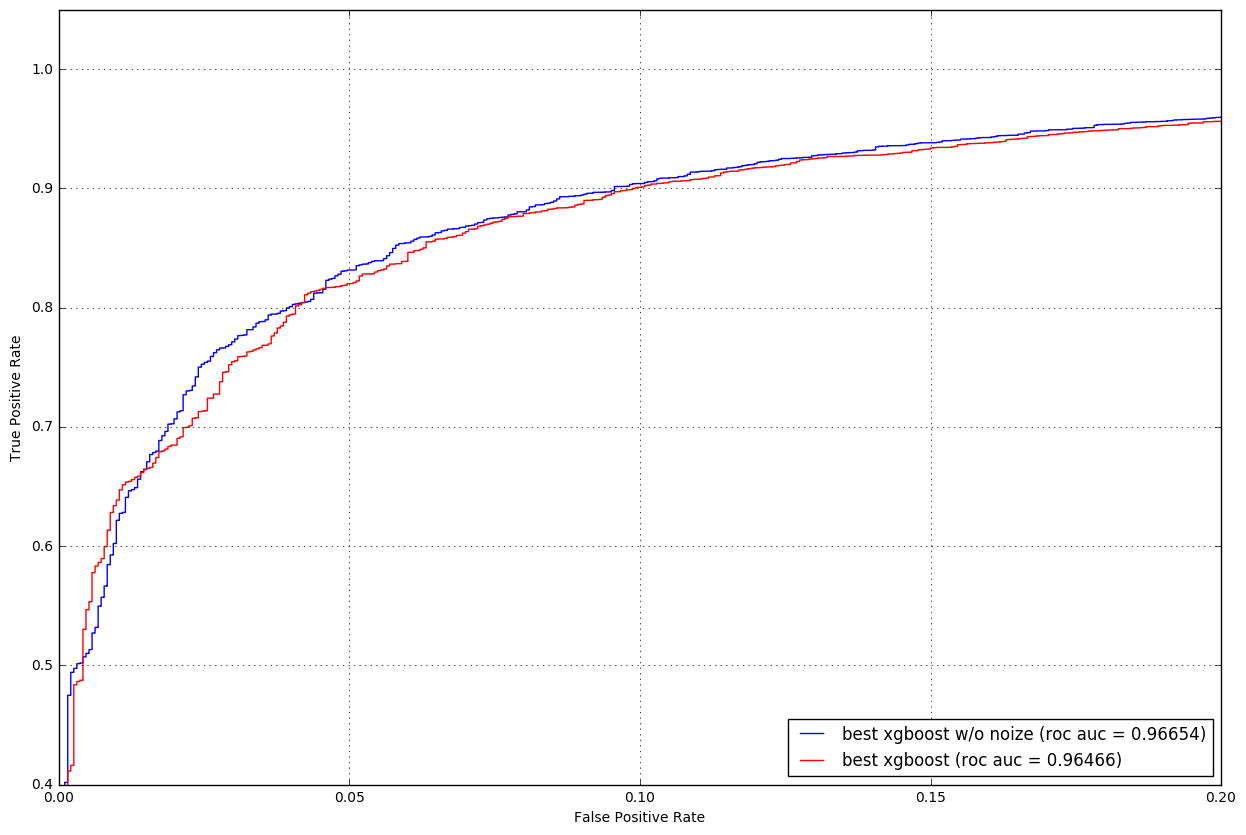

In [323]:
fpr7, tpr7, _ = roc_curve(events_labels7, events_proba7, sample_weight=events_weights7)

fpr6, tpr6, _ = roc_curve(events_labels6, events_proba6, sample_weight=events_weights6)



plt.figure(figsize=[15, 10])
lw = 1
plt.plot(fpr7, tpr7, color='b',
         lw=lw, label='best xgboost w/o noize (roc auc = %0.5f)' % roc_auc_score(events_labels7, events_proba7, sample_weight=events_weights7))
plt.plot(fpr6, tpr6, color='r',
         lw=lw, label='best xgboost (roc auc = %0.5f)' % roc_auc_score(events_labels6, events_proba6, sample_weight=events_weights6))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 0.2])
plt.ylim([0.4, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()